# Learning Objectives

- Illustrate monitoring workflows as a key component of MLOps practise.
- Present statisical models to monitor models in production for different types of drift.

# Setup

In [1]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 18.2 MB/s eta 0:00:00


In [2]:
import math

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
sns.set_context('talk')

# Monitoring Setup

## Access Training Data

In [4]:
dataset = fetch_openml(data_id=42890, as_frame=True, parser="auto")

data_df = dataset.data

target = 'Machine failure'
numeric_features = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]'
]
categorical_features = ['Type']

X = data_df[numeric_features + categorical_features]
y = data_df[target]

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

## Access Logs

We connect to the dataset of all the production logs and extract a 30% random sample to execute the monitoring workflow.

In [5]:
prediction_logs = load_dataset("pgurazada1/machine-failure-mlops-demo-logs")

Generating train split:   0%|          | 0/1259 [00:00<?, ? examples/s]

In [6]:
prediction_logs_df = prediction_logs['train'].to_pandas()

In [7]:
prediction_logs_sample_df = prediction_logs_df.sample(frac=0.3, random_state=42)

In [8]:
prediction_logs_sample_df.sample(5)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type,prediction
209,298.5,309.5,1480,38.1,160,L,0
931,296.3,307.3,1368,49.5,10,M,0
244,297.8,308.4,1512,39.9,181,L,0
242,300.2,311.4,1483,44.4,141,L,0
140,300.9,311.3,1668,28.9,183,H,0


# Model Drift Checks

## Check 1: Predicted Targets vs Training Targets

This check is applied when the ground truth is not observed instantaneously. Here we compare the distributions of the targets in the sample with those observed in training data. A rule of thumb here is that these two distributions should match (for e.g., the proportion of positive labels should be roughly the same).

In the current example, let us assume that the ground truth (i.e., whether the machine failed or not) is not instantaneously available. We can then compare the distributions of the targets from the logs and those in training data like so:

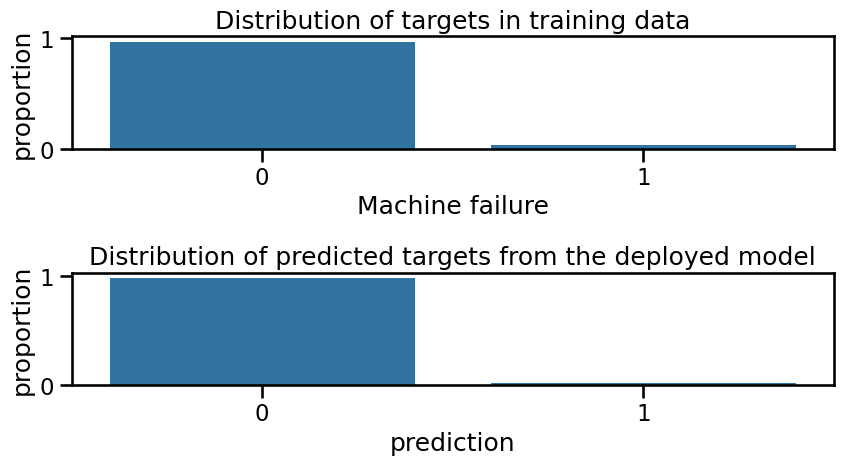

In [9]:
plt.figure(figsize=(9, 5))
plt.subplot(211)
sns.countplot(x=ytrain, stat='proportion')
plt.title("Distribution of targets in training data")
plt.subplot(212)
sns.countplot(x=prediction_logs_sample_df.prediction, stat='proportion')
plt.title("Distribution of predicted targets from the deployed model")
plt.tight_layout()

The above plot indicates variation in the distributions between training targets and predicted targets. However, this variation is observed in a sample. How do we confirm that this is not an artifact of the sample? We answer this question by formalizing the thumb rule presented above as the following test: Let the proportion of the positive labels in training data (of size $n$) is $p$. Then the proportion of positive labels in the sample of prediction logs can be different from $p$ by at most $2\sqrt{p(1-p)/n}$ (i.e., the difference is no more than two standard deviations away). This logic is implemented in the code cells below:

In [10]:
ytrain.value_counts()

Machine failure
0    7722
1     278
Name: count, dtype: int64

In [11]:
prediction_logs_sample_df.prediction.value_counts()

prediction
0    371
1      7
Name: count, dtype: int64

In [12]:
p_pos_label_training_data = 278/(7722+278)
p_pos_label_sample_logs = 2/214

In [13]:
p_pos_label_training_data, p_pos_label_sample_logs

(0.03475, 0.009345794392523364)

In [14]:
# @title Target Check

p_pos_label_training_data = 0.03475 # @param
p_pos_label_sample_logs = 0.00934 # @param
training_data_size = 8000 # @param

variance = (p_pos_label_training_data * (1-p_pos_label_training_data))/training_data_size
p_diff = abs(p_pos_label_training_data - p_pos_label_sample_logs)

if p_diff > 2 * math.sqrt(variance):
    print("Model Drift Detected!")
else:
    print("No Model Drift!")


Model Drift Detected!


## Check 2: Predicted Targets vs Ground Truth

This check is applied when ground truth is observed instantaneously. Numerically this is not different from check 1 (i.e., the proportion of positive labels should be roughly the same in the predicted targets and the ground truths). The methodology presented in the previous section still holds.

# Data Drift Checks

We define data drift as the phenomenon of deviation or changes occurring between the distribution or characteristics of the training features and the corresponding live features used for real-time predictions or analysis. It indicates a shift in the underlying data generating process and can have significant implications for the performance and reliability of machine learning models or data-driven systems. Here are a few examples of data drift:

Example of Numeric Data Drift: Imagine a predictive model trained on historical sales data of a retail store. The model learns patterns and relationships between features such as product price, customer demographics, and time of purchase. Over time, if there is a shift in customer behavior, such as a change in purchasing preferences or economic conditions, the distribution of live data features (e.g., customer income levels) may deviate from the training data. This data drift can impact the accuracy and effectiveness of the model's predictions.

Example of Categorical Data Drift: Consider a customer churn prediction model trained on telecom customer data. The model learns from features like customer demographics, subscription plans, and service usage patterns. However, if there are changes in the market or industry regulations, new subscription plans may be introduced or existing plans may be modified. These changes can lead to shifts in the distribution of live data features, such as the introduction of new plan categories or changes in service usage patterns, causing data drift that can affect the model's ability to accurately predict customer churn.

## Check 3: Live Features vs Training Features

Categorical data drift can be checked using the proportion test described in the previous section.

For numerical features, we use the following thumb rule: The mean of a numeric feature in production logs can be at most 2 standard deviations away from its mean in the training data. Note that here we are comparing a point estimate of production data accounting for expected variation in sampling.

Let us implement this thumb rule for one numeric feature: Tool wear (min).

In [15]:
mean_tool_wear_training_data = Xtrain['Tool wear [min]'].mean()
std_tool_wear_training_data = Xtrain['Tool wear [min]'].std()

mean_tool_wear_sample_logs = prediction_logs_sample_df['Tool wear [min]'].mean()

In [16]:
(mean_tool_wear_training_data, mean_tool_wear_sample_logs)

(108.06875, 115.39682539682539)

In [17]:
std_tool_wear_training_data

63.22505199157544

In [18]:
# @title Feature Distribution Check

mean_feature_training_data = 108.07 # @param
mean_feature_sample_logs = 118.94 # @param
std_feature_training_data = 63.23 # @param

mean_diff = abs(mean_feature_training_data - mean_feature_sample_logs)

if mean_diff > 2 * std_feature_training_data:
    print("Data Drift Detected!")
else:
    print("No Data Drift!")


No Data Drift!


The current model stays in production unless we detect model drift or data drift.